# A/B-тестирование воронки продаж онлайн-школы психологии

---

- Автор: Проценко Игорь
- Дата:11.12.2025

## Цели и задачи проекта
---

### Задача: 

`Проанализировать результаты A/B-теста, направленного на увеличение конверсии лидов в продажи`, 

и выяснить, правда ли, что новая версия лендинга (группа B) приводит к статистически значимому увеличению конверсии по сравнению со старой версией (группа A).

---

### Гипотезы:

`Нулевая гипотеза (H0):` Конверсия из лида в продажу в группе B не выше чем в группе A.
μ_B ≤ μ_A

`Альтернативная гипотеза (H1):` Конверсия из лида в продажу в группе B статистически значимо выше чем в группе A.
μ_B > μ_A

`Метрика:` Конверсия = (число продаж в группе) / (число лидов в группе)

## Описание данных

---

**Данные:**

`leads.csv` — таблица с лидами (заявками).

`sales.csv` — таблица с продажами.

`ab_assignments.csv` — таблица с распределением лидов по группам A/B-теста.

<div class="alert alert-info">
<h3> Структура ключевых таблиц: <a class="tocSkip"> </h3>

---

**ab_assignments.csv:**

`test_id` — идентификатор теста;

`test_name` — название теста;

`test_objective` — цель теста;

`test_start_date` — дата начала теста;

`test_end_date` — дата окончания теста;

`lead_id` — уникальный идентификатор лида;

`user_id` — уникальный идентификатор пользователя;

`campaign_id` — идентификатор рекламной кампании;

`utm_source` — источник трафика;

`utm_medium` — канал трафика;

`test_group` — группа теста (A — контроль, B — тестовая);

`assigned_at` — дата и время распределения в группу.

---
**leads.csv:**

`lead_id` — уникальный идентификатор лида;

`user_id` — уникальный идентификатор пользователя;

`created_at` — дата и время создания лида.

---
**sales.csv:**

`sale_id` — уникальный идентификатор продажи;

`lead_id` — идентификатор лида, по которому прошла продажа;

`user_id` — идентификатор пользователя;

`sale_date` — дата и время продажи.
    
</div>

## Содержимое проекта

---

***Структура проекта***

`1. Знакомство с данными`

- Анализ основных статистик по таблицам (размеры, типы данных, пропуски).

- Изучение распределение групп в A/B тесте.

- Проверка временных периодов теста.

`2. Предобработка данных`

- Объединение таблиц.

- Проверка на дубликаты, аномалии.

- Формирование финальной таблицы для анализа (лид + группа теста + факт продажи).

`3. Проверка гипотезы`

- Расчет конверсий.

- Визуализация распределений.

- Проверка статистических тестов (z-тест для пропорций, t-тест для средних).

- Интерпретация p-value.

`4. Итоговые выводы`

- Принимаем или отвергаем гипотезу.

- Практические рекомендации.

## 1. Загрузка данных и знакомство с ними

Загружаем все библиотеки и таблицы в проект и изучаем данные.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Загрузка данных с правильным разделителем
leads = pd.read_csv('online_school_data/leads.csv', sep=';', parse_dates=['created_at'])
sales = pd.read_csv('online_school_data/sales.csv', sep=';', parse_dates=['sale_date'])
ab_assignments = pd.read_csv('online_school_data/ab_assignments.csv', sep=';', parse_dates=['assigned_at', 'test_start_date', 'test_end_date'])

print("Данные загружены:")
print(f"leads: {leads.shape}")
print(f"sales: {sales.shape}")
print(f"ab_assignments: {ab_assignments.shape}")

Данные загружены:
leads: (59288, 9)
sales: (12660, 7)
ab_assignments: (500, 12)


In [10]:
# Базовое знакомство с данными
print("\n1. Таблица ab_assignments (распределение по тесту):")

print(ab_assignments.info())

print("\nПервые 5 строк:")
display (ab_assignments.head())


1. Таблица ab_assignments (распределение по тесту):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   test_id          500 non-null    object        
 1   test_name        500 non-null    object        
 2   test_objective   500 non-null    object        
 3   test_start_date  500 non-null    datetime64[ns]
 4   test_end_date    500 non-null    datetime64[ns]
 5   lead_id          500 non-null    object        
 6   user_id          500 non-null    object        
 7   campaign_id      500 non-null    object        
 8   utm_source       500 non-null    object        
 9   utm_medium       500 non-null    object        
 10  test_group       500 non-null    object        
 11  assigned_at      500 non-null    datetime64[ns]
dtypes: datetime64[ns](3), object(9)
memory usage: 47.0+ KB
None

Первые 5 строк:


,test_id,test_name,test_objective,test_start_date,test_end_date,lead_id,user_id,campaign_id,utm_source,utm_medium,test_group,assigned_at
0,2024_landing_test_v1,Landing Page Redesign Test,Increase lead-to-sale conversion,2023-01-01,2023-06-01,lead_a512127651c1,user_138471,yandex_direct_psycho_jan2023,yandex,direct,A,2023-02-18 21:48:10
1,2024_landing_test_v1,Landing Page Redesign Test,Increase lead-to-sale conversion,2023-01-01,2023-06-01,lead_cc71f719d844,user_251405,partners_cpa_psycho_may2023,partners,cpa,B,2023-05-14 04:03:46
2,2024_landing_test_v1,Landing Page Redesign Test,Increase lead-to-sale conversion,2023-01-01,2023-06-01,lead_62ee0825def3,user_103530,yandex_cpc_psycho_jan2023,yandex,cpc,B,2023-01-16 01:23:37
3,2024_landing_test_v1,Landing Page Redesign Test,Increase lead-to-sale conversion,2023-01-01,2023-06-01,lead_2a9d0c2fbb63,user_170358,yandex_cpc_psycho_mar2023,yandex,cpc,B,2023-03-05 11:42:32
4,2024_landing_test_v1,Landing Page Redesign Test,Increase lead-to-sale conversion,2023-01-01,2023-06-01,lead_ef72a9469d06,user_128633,partners_cpa_psycho_jan2023,partners,cpa,A,2023-01-13 21:22:22


In [11]:
print("\n\n2. Распределение по группам:")
group_counts = ab_assignments['test_group'].value_counts()
print(group_counts)



2. Распределение по группам:
B    259
A    241
Name: test_group, dtype: int64


In [12]:
print("\n\n3. Проверка временного периода теста:")
print(f"Дата начала теста: {ab_assignments['test_start_date'].min()}")
print(f"Дата окончания теста: {ab_assignments['test_end_date'].max()}")
print(f"Фактический период распределения лидов: от {ab_assignments['assigned_at'].min()} до {ab_assignments['assigned_at'].max()}")



3. Проверка временного периода теста:
Дата начала теста: 2023-01-01 00:00:00
Дата окончания теста: 2023-06-01 00:00:00
Фактический период распределения лидов: от 2023-01-02 09:51:33 до 2023-05-31 13:57:36


In [13]:
print("\n\n4. Проверка связи с таблицей leads:")
# Сколько лидов из ab_assignments есть в leads?
common_leads = ab_assignments['lead_id'].isin(leads['lead_id']).sum()
print(f"Лидов из A/B теста, найденных в leads: {common_leads} из {len(ab_assignments)}")



4. Проверка связи с таблицей leads:
Лидов из A/B теста, найденных в leads: 500 из 500


## Выводы после знакомства с данными:

---
<div class="alert alert-info">
<h3> Объём данных: <a class="tocSkip"> </h3>


В A/B тесте участвуют `500 лидов`, распределённых по группам `A (241 лид)` и `B (259 лидов)`. Распределение практически равномерное, что корректно для проведения теста.

---
<h3> Период проведения теста: <a class="tocSkip"> </h3>


`Тест проводился с 1 января 2023 по 1 июня 2023 года`. Фактические распределения лидов происходили в течение всего периода (с 2 января по 31 мая), что соответствует заявленному времени теста.

---
<h3> Качество данных:  <a class="tocSkip"> </h3>

    
Пропусков в данных нет (все столбцы содержат по 500 непустых значений).

Все лиды из таблицы `ab_assignments` присутствуют в основной таблице `leads` (500 из 500), что означает целостность данных.

---

## 2. Предобработка данных

Необходимо объединить таблицы `ab_assignments` и `leads`, а затем добавить информацию о продажах `sales`, чтобы получить финальный датафрейм для анализа конверсии.

In [14]:
# 1. Объединяем лиды с информацией о группе теста
df = leads.merge(ab_assignments[['lead_id', 'test_group']], on='lead_id', how='inner')
print(f"1. После объединения leads и ab_assignments: {df.shape[0]} строк")

1. После объединения leads и ab_assignments: 500 строк


In [15]:
# 2. Добавляем информацию о продажах
df['has_sale'] = df['lead_id'].isin(sales['lead_id']).astype(int)
print(f"2. Добавлен признак has_sale (1 — была продажа, 0 — нет)")

2. Добавлен признак has_sale (1 — была продажа, 0 — нет)


In [16]:
# 3. Проверяем дубликаты лидов (их не должно быть)
duplicates = df.duplicated(subset='lead_id').sum()
print(f"3. Дубликатов lead_id: {duplicates}")

3. Дубликатов lead_id: 0


In [18]:
# 4. Проверяем распределение конверсии по группам
conv_stats = df.groupby('test_group')['has_sale'].agg(['count', 'sum'])
conv_stats['conversion_rate'] = conv_stats['sum'] / conv_stats['count'] * 100
print("\n4. Конверсия по группам на этапе предобработки:")
display(conv_stats)


4. Конверсия по группам на этапе предобработки:


,count,sum,conversion_rate
test_group,,,
A,241,50,20.746888
B,259,58,22.393822


## Выводы после предобработки данных:

---
<div class="alert alert-info">
<h3> Итоговый датасет: <a class="tocSkip"> </h3>


Сформирован финальный датафрейм из `500 лидов`, каждый из которых принадлежит либо к группе `A (контрольная)`, либо к группе `B (тестовая)`.

---
<h3> Конверсия по группам (предварительная): <a class="tocSkip"> </h3>


`Группа A`: 50 продаж из 241 лида → конверсия `20.75%`.

`Группа B`: 58 продаж из 259 лидов → конверсия `22.39%`.

`Разница (B - A)`: +1.65%.

---
<h3> Качество данных подтверждено:  <a class="tocSkip"> </h3>

    
Дубликатов лидов нет, пропуски отсутствуют.

Данные готовы для статистического анализа.

---

## 3. Проверка гипотез

Необходимо определить, является ли разница в конверсии статистически значимой или она может быть объяснена случайными колебаниями.

In [19]:
# Данные для анализа
conv_a = conv_stats.loc['A', 'sum']  # число продаж в группе A
n_a = conv_stats.loc['A', 'count']   # всего лидов в группе A
conv_b = conv_stats.loc['B', 'sum']  # число продаж в группе B
n_b = conv_stats.loc['B', 'count']   # всего лидов в группе B

p_a = conv_a / n_a
p_b = conv_b / n_b

print(f"Конверсия группы A: {p_a:.4f} ({conv_a}/{n_a})")
print(f"Конверсия группы B: {p_b:.4f} ({conv_b}/{n_b})")
print(f"Разница (B - A): {p_b - p_a:.4f}")

Конверсия группы A: 0.2075 (50/241)
Конверсия группы B: 0.2239 (58/259)
Разница (B - A): 0.0165


In [21]:
# 1. Z-тест для разницы пропорций (двухвыборочный)
from statsmodels.stats.proportion import proportions_ztest

# Объединяем данные для z-теста
count = [conv_a, conv_b]
nobs = [n_a, n_b]

# Двусторонний тест (проверяем, что пропорции разные)
zstat, p_value_two_sided = proportions_ztest(count, nobs, alternative='two-sided')

# Односторонний тест (проверяем, что конверсия в B > A)
_, p_value_one_sided = proportions_ztest(count, nobs, alternative='larger')

print(f"\n1. Результаты Z-теста:")
print(f"   Z-статистика: {zstat:.4f}")
print(f"   p-value (двусторонний): {p_value_two_sided:.4f}")
print(f"   p-value (односторонний, B > A): {p_value_one_sided:.4f}")


1. Результаты Z-теста:
   Z-статистика: -0.4472
   p-value (двусторонний): 0.6548
   p-value (односторонний, B > A): 0.6726


In [22]:
# 2. Доверительный интервал для разницы пропорций
from statsmodels.stats.proportion import confint_proportions_2indep

ci_low, ci_high = confint_proportions_2indep(conv_b, n_b, conv_a, n_a, method='wald', compare='diff')

print(f"\n2. Доверительный интервал 95% для разницы (B - A): [{ci_low:.4f}, {ci_high:.4f}]")


2. Доверительный интервал 95% для разницы (B - A): [-0.0556, 0.0886]


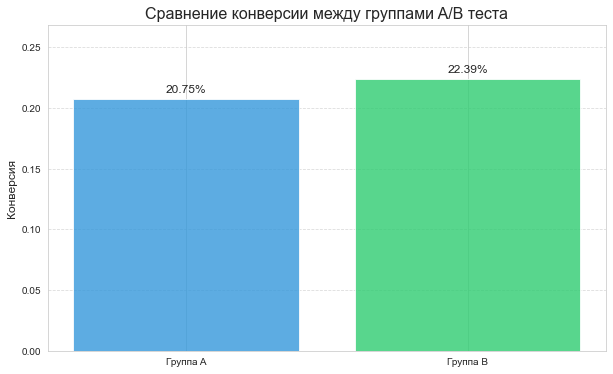

In [23]:
# 3. Визуализация
plt.figure(figsize=(10, 6))
groups = ['Группа A', 'Группа B']
convs = [p_a, p_b]
colors = ['#3498db', '#2ecc71']

plt.bar(groups, convs, color=colors, alpha=0.8)
plt.ylabel('Конверсия', fontsize=12)
plt.title('Сравнение конверсии между группами A/B теста', fontsize=16)
plt.ylim(0, max(convs) * 1.2)

# Добавим значения на столбцы
for i, v in enumerate(convs):
    plt.text(i, v + 0.005, f'{v:.2%}', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Итоговые выводы по проекту A/B-теста:

---
<div class="alert alert-info">
    
<h3> Статистический анализ: <a class="tocSkip"> </h3>


`Z-тест для пропорций не выявил` статистически значимой разницы:

p-value (односторонний, B > A) = 0.6726 (> 0.05).

`Доверительный интервал 95% для разницы:` [-5.56%, +8.86%].

Интервал включает ноль и отрицательные значения.

Это означает, что истинная разница может быть отрицательной (A лучше B) или нулевой.

---
<h3> Решение по гипотезам:  <a class="tocSkip"> </h3>

`Нулевая гипотеза (H0)`: Конверсия в группе B не выше, чем в группе A — **НЕ ОТВЕРГАЕТСЯ**.

`Альтернативная гипотеза (H1)`: Конверсия в группе B статистически значимо выше — **НЕ ПОДТВЕРЖДАЕТСЯ**.

---

## 4. Выводы и практические рекомендации

Определяем, является ли разница в конверсии статистически значимой или она может быть объяснена случайными колебаниями.

`Внедрять новую версию (лендинг группы B) не рекомендуется` — нет доказательств её эффективности.

---

### Возможные причины отсутствия эффекта:

- Изменения были слишком незначительными.

- Недостаточный объём выборки для обнаружения малых различий.

- Метрика «конверсия в продажу» может быть не самой чувствительной.

### Дальнейшие шаги:

- Провести качественный анализ (опросы пользователей).

- Рассмотреть другие метрики (средний чек, retention).

- При повторном тесте увеличить выборку и продолжительность.

## Итог:

A/B-тест не показал статистически значимого улучшения конверсии от новой версии лендинга. 

Разница в 1.65% может быть обусловлена случайными колебаниями. 

Решение о внедрении изменений должно основываться на дополнительных исследованиях.